# Error propagation in the pendulum
The purpose of this tutorial notebook is to demonstrate analytic error propagation with the pendulum. We need to obtain a prediction of the expected uncertainty to compare to the uncertainty output by the various statistical and ML Uncertainty Quantification (UQ) methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# deepbench unfortunately still has to be installed with pip:
# pip install deepbench==0.2.2
import deepbench
from deepbench.physics_object import Pendulum

## Instantiate a pendulum object with noise
Here the noise will be on the theta parameter. Let's explore how deepbench creates noise as a function of time.

In [2]:
true_L = 1.0
true_theta = np.pi / 100
true_a = 9.8
# here, we will introduce a 10% error on the theta parameter
# and no error on any other parameters
percent_error = 0.3

# generate a pendulum object from deepbench
pendulum = Pendulum(
            pendulum_arm_length=true_L,
            starting_angle_radians=true_theta,
            acceleration_due_to_gravity=true_a,
            noise_std_percent={
                "pendulum_arm_length": 0.0,
                "starting_angle_radians": percent_error,
                "acceleration_due_to_gravity": 0.0,
            },
        )
# so in deepbench, noise is created by modifying the parameter value,
# using a random normal centered at the previous parameter value
# and a standard deviation which is scaled by this value multiplied by 
# the noise_level, which is effectively a true value standard deviation
# so percent_error = 0.5 should create noise on theta_0 that is
# 50% of the value at each moment in time

Now demonstrate the noise generation for a a series of moments in time. If you run this cell multiple times it will include different noisy draws.

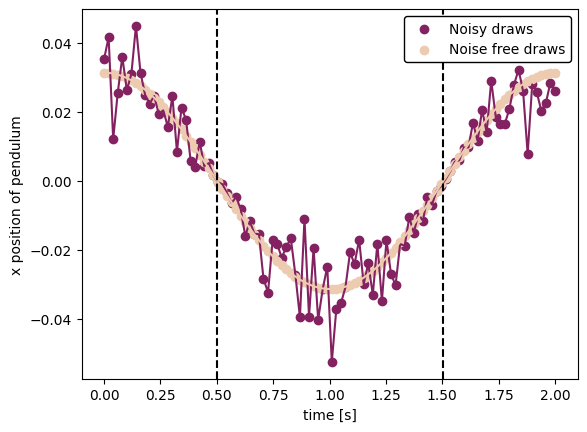

In [3]:
times = np.linspace(0,2,100)

# generate a noisy and a noiseless instance
pendulum_noisy = pendulum.create_object(times, noiseless=False)
pendulum_noiseless = pendulum.create_object(times, noiseless=True)


plt.clf()
plt.plot(times, pendulum_noisy, color = '#832161')
plt.scatter(times, pendulum_noisy, label = 'Noisy draws', color = '#832161')
plt.plot(times, pendulum_noiseless, color = '#EDCBB1')
plt.scatter(times, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.axvline(x = (np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')
plt.axvline(x = (3 * np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')

plt.show()

Okay but this was one random noisy pendulum, to get a better idea of the type of noise we can expect, let's iterate many times to create many noisy pendulum objects and then plot 1$\sigma$ confidence intervals.

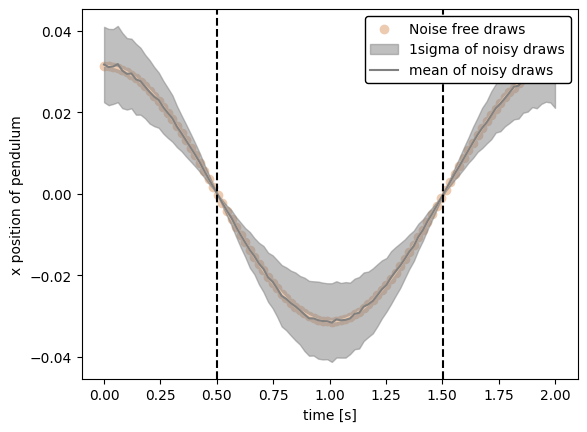

In [4]:
# 1000 noisy pendulums:
pendulum_noisy_list = np.zeros((len(times),1000))
for r in range(1000):
    pendulum_noisy_list[:,r] = pendulum.create_object(times, noiseless=False)

# make one pendulum with no noise
pendulum_noiseless = pendulum.create_object(times, noiseless=True)

# now take the mean and standard deviation from all these noisy pendulums:
mean_trajectory = np.mean(pendulum_noisy_list, axis = 1)
std_trajectory = np.std(pendulum_noisy_list, axis = 1)

plt.clf()
plt.plot(times, pendulum_noiseless, color = '#EDCBB1')
plt.scatter(times, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
plt.fill_between(times, mean_trajectory - std_trajectory, mean_trajectory + std_trajectory,
                 color = 'grey', alpha = 0.5, label = '1sigma of noisy draws')
plt.plot(times, mean_trajectory, color = 'grey', label = 'mean of noisy draws')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')

# plot vertical lines where the time is intervals of pi/2 / sqrt(a/L), 
# which is where the trigonometry drives the dx value to zero
plt.axvline(x = (np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')
plt.axvline(x = (3 * np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')

plt.show()

You might notice that the noisy is time-variable on a periodic function with minimas at mutiples of pi/2. In order to best understand this and avoid a time dependence for the noise, let's understand this for only one moment in time.

https://www.youtube.com/watch?v=7L9EMe-7Z4w&ab_channel=MinhaCole%C3%A7%C3%A3oDeDVDs

Let's generate a bunch of noisy iterations of this pendulum object at one time (t = 0.75) and prove that these align with our expectation from the noisy pendulum simulator.

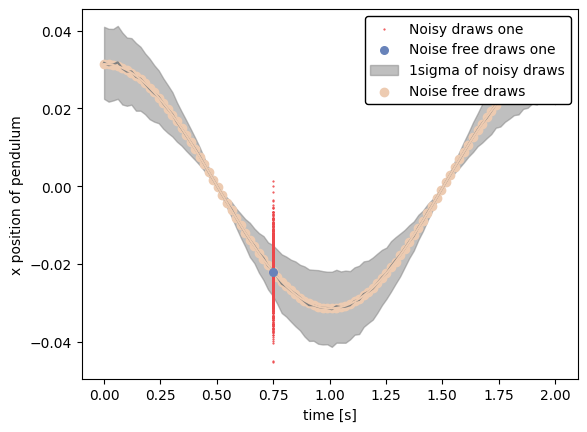

In [5]:
one_time = 0.75

pendulum_noiseless_one = pendulum.create_object(one_time, noiseless=True)

plt.clf()
for i in range(1000):
    pendulum_noisy_one = pendulum.create_object(one_time, noiseless=False)
    if i == 0:
        plt.scatter(one_time, pendulum_noisy_one, label = 'Noisy draws one',
                    color = '#ED474A', zorder = 100, s = 0.3)
    else:
        plt.scatter(one_time, pendulum_noisy_one, color = '#ED474A', zorder = 100,
                    s = 0.3)
plt.scatter(one_time, pendulum_noiseless_one, label = 'Noise free draws one', 
            color = '#6883BA', zorder = 100, s = 30)
plt.fill_between(times, mean_trajectory - std_trajectory, mean_trajectory + std_trajectory,
                 color = 'grey', alpha = 0.5, label = '1sigma of noisy draws')
plt.plot(times, mean_trajectory, color = 'grey')
plt.plot(times, pendulum_noiseless, color = '#EDCBB1')
plt.scatter(times, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.show()

Okay so the spread of the red draws from pendulum for one moment in time seem to line up with our expectation for the 1$\sigma$ jitter at that moment in time. But how does do we actually expect this error to propagate?

For a review of error propagation, see the 'Simple Uncertainty Propagation' section of https://docs.google.com/document/d/1uAt3-yi-eH14hs95wGvF3qokyWpINpkoKDYHVglkeO0/edit?usp=sharing.

To summarize briefly here, error propagation can be predicted using partial derivatives relative to the parameters. 

Here:

$$x = f(L,\theta_0,a_g)$$

$$dx = \frac{\partial f}{\partial L} dL + \frac{\partial f}{\partial \theta_0} d \theta_0 + \frac{\partial f}{\partial a_g} da_g$$

where $dx$ is the absolute error on x, $dL$, $d\theta_0$, and $da_g$ are the absolute errors on the parameters, which is the percent error multiplied by the parameter value.

In our case, if $dL = da_g = 0$, we only need to deal with the partial with respect to $\theta_0$:

$$x = L \ sin(\theta_0 \ cos (\sqrt{\frac{a_g}{L}} t))$$

$$dx = \frac{\partial f}{\partial \theta_0} d \theta_0  = L \ cos(\theta_0\ cos(\sqrt{\frac{a_g}{L}}\ t)) \ cos(\sqrt{\frac{a_g}{L}} \ t) d\theta_0$$

Okay, but that's just relative to $\theta_0$. You can see that there are two cosine functions that zero out at multiples of $(\pi / 2) * \sqrt{\frac{a_g}{L}}$. 

Let's rerun this analysis with error relative to L and $a_g$. First, L.

$$dx = \frac{\partial f}{\partial L} d L  = (\ sin(\theta_0 \ cos (\sqrt{\frac{a_g}{L}} t)) + \frac{1}{2} \ \theta_0 \ t \ \sqrt{\frac{a_g}{L}} \ sin(t\ \sqrt{\frac{a_g}{L}}) \ cos(\theta_0 \ cos(t \ \sqrt{\frac{a_g}{L}})))  * dL$$

Now relative to $a_g$ only.

$$dx = \frac{\partial f}{\partial a_g} d a_g  = (-\frac{1}{2}\sqrt{\frac{L}{a_g}} \theta_0 \ t \ sin(\sqrt{\frac{a_g}{L}}\ t) \ cos(\theta_0\ cos(\sqrt{\frac{a_g}{L}}t)))   * da_g$$

Below is the more general error propagation formula that combines all of these three relative formulae. It also includes an option for wrt == 'all' (with respect to), where dthing is now a list with [dL, dtheta, da].

In [6]:
# how should the error propagate? 
# its all partial derivatives
def calc_error_prop(true_L, true_theta, true_a, dthing, time, wrt = 'theta_0'):
    if wrt == 'theta_0':
        dx_dthing = true_L * np.cos(true_theta * np.cos(np.sqrt(true_a / true_L) * time)) * \
              np.cos(np.sqrt(true_a / true_L) * time) * dthing
    if wrt == 'L':
        dx_dthing = (0.5 * true_theta * time * np.sqrt(true_a / true_L) * np.sin(time * np.sqrt(true_a / true_L)) * \
             np.cos(true_theta * np.cos(time * np.sqrt(true_a / true_L))) + \
             np.sin(true_theta * np.cos(time * np.sqrt(true_a / true_L)))) * dthing
    if wrt == 'a_g':
        dx_dthing = (- 0.5 * np.sqrt(true_L / true_a) * true_theta * time * \
            np.sin(np.sqrt(true_a / true_L) * time) * \
            np.cos(true_theta * np.cos(np.sqrt(true_a / true_L) * time))) * dthing
    if wrt == 'all':
        dx_dthing = true_L * np.cos(true_theta * np.cos(np.sqrt(true_a / true_L) * time)) * \
              np.cos(np.sqrt(true_a / true_L) * time) * dthing[1] + \
                    (0.5 * true_theta * time * np.sqrt(true_a / true_L) * np.sin(time * np.sqrt(true_a / true_L)) * \
             np.cos(true_theta * np.cos(time * np.sqrt(true_a / true_L))) + \
             np.sin(true_theta * np.cos(time * np.sqrt(true_a / true_L)))) * dthing[0] + \
                    (- 0.5 * np.sqrt(true_L / true_a) * true_theta * time * \
            np.sin(np.sqrt(true_a / true_L) * time) * \
            np.cos(true_theta * np.cos(np.sqrt(true_a / true_L) * time))) * dthing[2]
    return abs(dx_dthing)


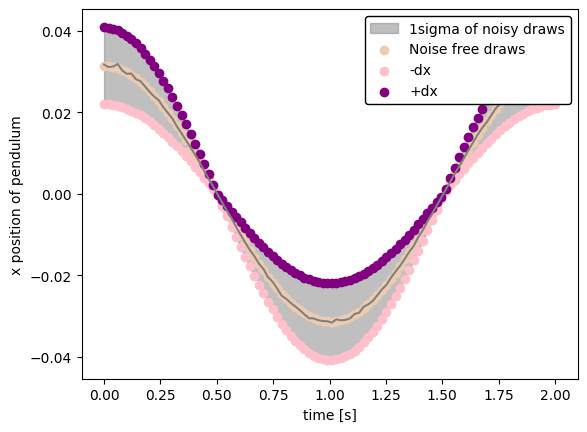

In [7]:
plt.clf()
plt.fill_between(times, mean_trajectory - std_trajectory, mean_trajectory + std_trajectory,
                 color = 'grey', alpha = 0.5, label = '1sigma of noisy draws')
plt.plot(times, mean_trajectory, color = 'grey')

plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')

# okay but also compare to our expectation for noise value

dx = calc_error_prop(true_L, true_theta, true_a,
                              percent_error * true_theta,
                              time = one_time, wrt = 'theta_0')



# try to do this for multiple times
dx_list = []
for t in times:
    dx_list.append(calc_error_prop(true_L, true_theta, true_a,
                              percent_error * true_theta,
                              time = t, wrt = 'theta_0'))
    

plt.scatter(times, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')

plt.scatter(times, pendulum_noiseless - dx_list, label= '-dx', color = 'pink')
plt.scatter(times, pendulum_noiseless + dx_list, label= '+dx', color = 'purple')


legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)


plt.show()


Great, looks like our expectation of the noise level from analytic error propagation matches that we get from many draws of the noisy pendulum. Another way to visualize this is to build histograms for a specific moment in time.

Okay so now compare 1000 draws from the x position of the noisy pendulum to the 1000 draws from the expected dx from the analytic error propagation multiplied by a draw from a standard normal.

$\theta_0$ =  0.031415926535897934 % error =  0.3 absolute error =  0.00942477796076938
x =  -0.022026972693845168 dx =  0.006607022879445159


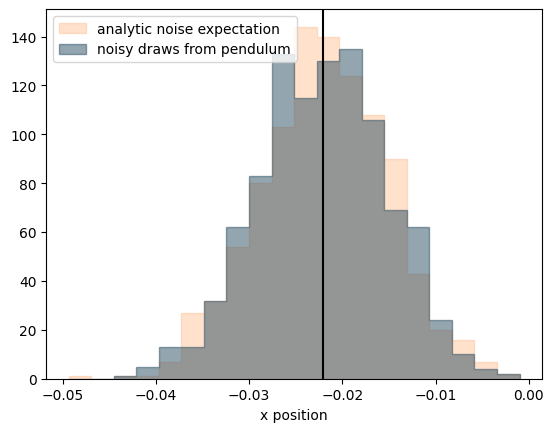

In [8]:
dx_dtheta_0 = calc_error_prop(true_L, true_theta, true_a,
                              percent_error * true_theta,
                              time = one_time, wrt = 'theta_0')

print(r'$\theta_0$ = ', true_theta, r'% error = ', percent_error, 'absolute error = ', percent_error * true_theta)
print('x = ', pendulum_noiseless_one, 'dx = ', dx_dtheta_0)


# first plot the predicted scatter
analytic_noise = []
for r in range(1000):
    rs = np.random.RandomState()#2147483648)# 
    attribute = rs.normal(loc=0, scale=1)
    analytic_noise.append(attribute * dx_dtheta_0 + pendulum_noiseless_one)
# then also doing 100 draws from the pendulum
noisy_pendulum = []
for r in range(1000):
    pendulum_noisy_one = pendulum.create_object(one_time, noiseless=False)
    noisy_pendulum.append(pendulum_noisy_one)

bins = 20
plt.clf()
# in order to have the same bins for both, do this:
bin_height, bin_center = np.histogram(analytic_noise, bins = bins)
plt.hist(analytic_noise,
         bins = bin_center, color = '#FFC49B', alpha = 0.5,
         label = 'analytic noise expectation',
         histtype='step', fill = True)
plt.hist(noisy_pendulum,
         bins = bin_center, color = '#294C60', alpha = 0.5,
         label = 'noisy draws from pendulum',
         histtype='step', fill = True)
plt.legend()
plt.xlabel('x position')
plt.axvline(x = pendulum_noiseless_one, color = 'black')
plt.show()

Do these match? Roughly yes.

Let's look at this same thing for introducing noise on the $L$ parameter, which has two components to the derivative.

First instantiate the pendulum again, this time the uncertainty will be in the L parameter.

In [9]:
# here, we will introduce a 50% error on the L parameter
# and no error on any other parameters

# generate a pendulum object from deepbench
pendulum = Pendulum(
            pendulum_arm_length=true_L,
            starting_angle_radians=true_theta,
            acceleration_due_to_gravity=true_a,
            noise_std_percent={
                "pendulum_arm_length": percent_error,
                "starting_angle_radians": 0.0,
                "acceleration_due_to_gravity": 0.0,
            },
        )

/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.9/lib/python3.9/site-packages/deepbench/physics_object/pendulum.py:302: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(acceleration_values / pendulum_arm_length_values) * time


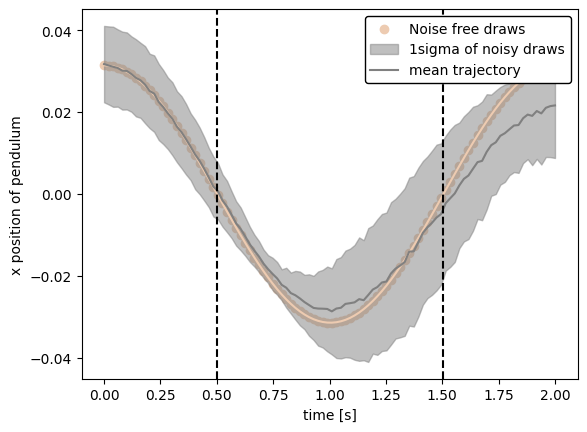

In [10]:
pendulum_noisy_list_L = np.zeros((len(times),1000))
for r in range(1000):
    pendulum_noisy_list_L[:,r] = pendulum.create_object(times, noiseless=False)

# gotta add this line because there's some bug that's generating nans in deepbench
# i think its related to the fact that we have some square roots so when a or L becomes negative we
# are in trouble
pendulum_noisy_list_L = np.ma.masked_invalid(pendulum_noisy_list_L)

# now take the mean and standard deviation
mean_trajectory_L = np.mean(pendulum_noisy_list_L, axis = 1)
std_trajectory_L = np.std(pendulum_noisy_list_L, axis = 1)

plt.clf()
plt.plot(times, pendulum_noiseless, color = '#EDCBB1')
plt.scatter(times, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
plt.fill_between(times, mean_trajectory_L - std_trajectory_L, mean_trajectory_L + std_trajectory_L,
                 color = 'grey', alpha = 0.5, label = '1sigma of noisy draws')
plt.plot(times, mean_trajectory_L, color = 'grey', label = 'mean trajectory')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.axvline(x = (np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')
plt.axvline(x = (3 * np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')

plt.show()

I'm drawing hte same verticle lines at the place where the expected error if there is only uncertainty in $\theta_0$ should be zero. This time you can see there is uncertainty at all values of time.

Let's compare this to the analytic expectation.

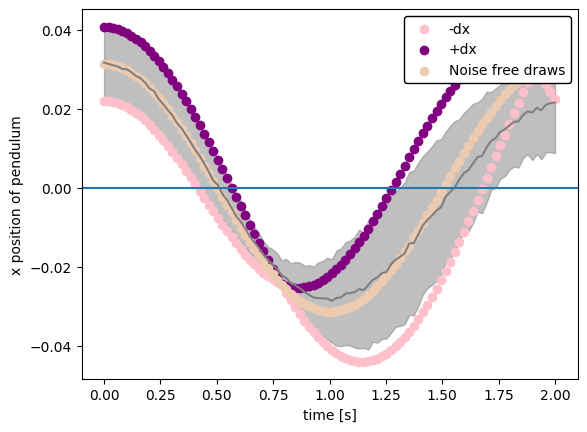

In [11]:
plt.clf()
plt.fill_between(times,
                 mean_trajectory_L - std_trajectory_L,
                 mean_trajectory_L + std_trajectory_L,
                 color = 'grey', alpha = 0.5)
plt.plot(times, mean_trajectory_L, color = 'grey')
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')



# try to do this for multiple times
dx_list_L = []
for t in times:
    dx_list_L.append(calc_error_prop(true_L, true_theta, true_a,
                              percent_error * true_L,
                              time = t, wrt = 'L'))
    
plt.scatter(times, pendulum_noiseless - dx_list_L, label= '-dx', color = 'pink')
plt.scatter(times, pendulum_noiseless + dx_list_L, label= '+dx', color = 'purple')

plt.scatter(times, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)

plt.axhline(y = 0)
#plt.axvline(x = )

plt.show()


Doing the same for $a_g$.

In [12]:
# here, we will introduce a 50% error on the a_g parameter
# and no error on any other parameters

# generate a pendulum object from deepbench
pendulum_a = Pendulum(
            pendulum_arm_length=true_L,
            starting_angle_radians=true_theta,
            acceleration_due_to_gravity=true_a,
            noise_std_percent={
                "pendulum_arm_length": 0.0,
                "starting_angle_radians": 0.0,
                "acceleration_due_to_gravity": percent_error,
            },
        )

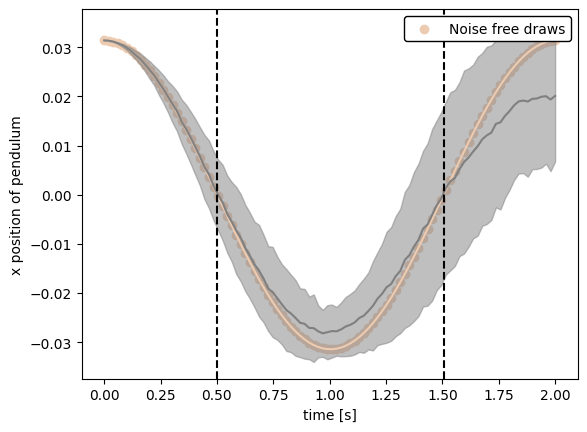

In [13]:
pendulum_noisy_list_a = np.zeros((len(times),1000))
for r in range(1000):
    noisy_trajectory_a = pendulum_a.create_object(times, noiseless=False)
    if np.isnan(noisy_trajectory_a.any()):
        print(noisy_trajectory_a)
        STOP
    pendulum_noisy_list_a[:,r] = noisy_trajectory_a

# gotta add this line because there's some bug that's generating nans in deepbench
# i think its related to the fact that we have some square roots so when a or L becomes negative we
# are in trouble
pendulum_noisy_list_a = np.ma.masked_invalid(pendulum_noisy_list_a)

# now take the mean and standard deviation
mean_trajectory_a = np.mean(pendulum_noisy_list_a, axis = 1)
std_trajectory_a = np.std(pendulum_noisy_list_a, axis = 1)

pendulum_noiseless_a = pendulum_a.create_object(times, noiseless=True)

plt.clf()
plt.plot(times, pendulum_noiseless, color = '#EDCBB1')
plt.scatter(times, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
plt.fill_between(times, mean_trajectory_a - std_trajectory_a,
                 mean_trajectory_a + std_trajectory_a,
                 color = 'grey', alpha = 0.5)
plt.plot(times, mean_trajectory_a, color = 'grey')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.axvline(x = (np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')
plt.axvline(x = (3 * np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')

plt.show()

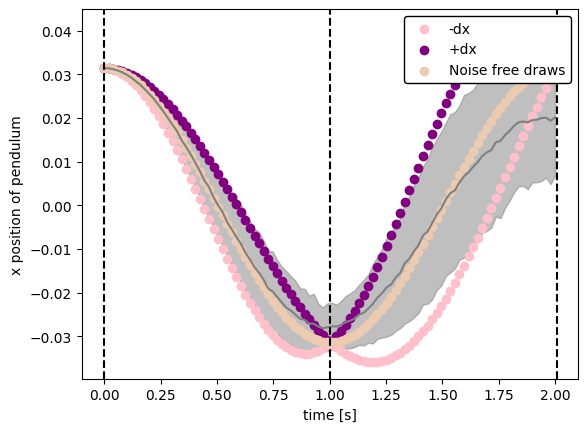

In [14]:
plt.clf()
plt.fill_between(times, mean_trajectory_a - std_trajectory_a,
                 mean_trajectory_a + std_trajectory_a,
                 color = 'grey', alpha = 0.5)
plt.plot(times, mean_trajectory_a, color = 'grey')

plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')



# try to do this for multiple times
dx_list_a = []
for t in times:
    dx_list_a.append(calc_error_prop(true_L, true_theta, true_a,
                              percent_error * true_a,
                              time = t, wrt = 'a_g'))

plt.scatter(times, pendulum_noiseless - dx_list_a, label = '-dx', color = 'pink')
plt.scatter(times, pendulum_noiseless + dx_list_a, label = '+dx', color = 'purple')

plt.scatter(times, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')

legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)

# this expression will be zero at multiples of sqrt(a/L) t = pi
plt.axvline(x = 0, ls = '--', color = 'black')
plt.axvline(x = np.pi / np.sqrt(true_a / true_L), ls = '--', color ='black')
plt.axvline(x = 2 * np.pi / np.sqrt(true_a / true_L), ls = '--', color ='black')


plt.show()
